# Melanoma Classification with Sequential Neural Network

In this notebook, a simple neural network based on the melanoma dataset will be build in order to assess initial performance.
The notebook works with data previously saved to the disk. To create this script, the model template was used.

The script that should be performed before this is the script: data_preparation_20192020.ipynb

<b>Running the script on cluster</b>

Please keep in mind the following
1. Load ALL images rather than a subset by changing to get_all_img_paths(img_folder) in Step 2 (get image paths 
2. The path to the data can be modified in Step 2 (get image paths + load data)
3. Make sure export is set to true
4. Save the results that are stored in the export folder and upload them seperately on google drive or github. The folder "export" is not tracked on github!!!

## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

 #### Random State

In [2]:
from utilities import random_state
import numpy as np

random_state = random_state() 
seed = np.random.seed(random_state)

#### Export Config

In [3]:
export_results = True
export_folder = f'export/SequentialNNM_Gridsearch'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### Timer

Start the timer

In [4]:
import time
start = time.time()

## 2. Get data

In [5]:
base_path = "data1920" # change this to the folder including your data
downsampled_data = False

#### Get image paths
For developing models on the cluster the max_images parameter should be removed. Instead call the method get_all_img_paths(img_folder).

In [6]:
from utilities import get_all_img_paths, get_img_paths

img_folder_train = base_path + "/train" + ("_downsampled" if downsampled_data else "")
img_folder_test = base_path + "/test" + ("_downsampled" if downsampled_data else "")
max_images_train = 800
max_images_test = 100

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load data
Loads the images specified in img_paths into a data frame. This includes resizing the images and flattening them into an array and may take a while.

In [7]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train" + ("_downsampled" if downsampled_data else "") + ".csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test" + ("_downsampled" if downsampled_data else "") + ".csv"

# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, img_paths_test, groundtruth_file_test, option);

Num images per thread 90
start loading train
start thread #0 for train
start loading test
start thread #1 for train
start thread #2 for train
start thread #0 for test
start thread #3 for train
start thread #4 for train
start thread #5 for train
start thread #6 for train
start thread #7 for train
finished thread #2 for train
finished thread #7 for train
finished thread #3 for train
finished thread #4 for train
finished thread #0 for train
finished thread #6 for train
finished thread #1 for train
finished thread #5 for train
done loading train
finished thread #0 for test
done loading test


#### Split into target and predictors

In [8]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

## 3. Train model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[49152]):
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Dropout(rate=0.2))
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', Recall(name="recall")])
    
    return model

In [10]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ReduceLROnPlateau 

keras_reg = KerasRegressor(build_model)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

class_weight = {0: 1.,
                1: 10.,}

keras_reg.fit(X_train, y_train, epochs=100, class_weight=class_weight,
              validation_data=(X_test, y_test),
              callbacks=[EarlyStopping(patience=10), lr_scheduler], verbose=0)
param_distribs = {
    "n_hidden": np.arange(1, 10),
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, random_state=random_state, verbose=0)

rnd_search_cv.fit(X_train, y_train, epochs=100, class_weight=class_weight,
                  validation_data=(X_test, y_test),
                  callbacks=[EarlyStopping(patience=10), lr_scheduler], verbose=0)

/tmp/ipykernel_2900057/763638452.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)
2022-11-01 22:50:09.606197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 22:50:09.606866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 22:50:09.607042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1

9/9 [==============================] - 0s 3ms/step - loss: 0.7667 - accuracy: 0.0977 - recall: 1.0000


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa30d166400>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa31c0df730>,
                                        'n_hidden': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42)

In [11]:
print(f"Randomized Search CV best params={rnd_search_cv.best_params_}")
print(f"Randomized Search CV best score={rnd_search_cv.best_score_}")

Randomized Search CV best params={'learning_rate': 0.0003920021771415983, 'n_hidden': 8, 'n_neurons': 24}
Randomized Search CV best score=-0.715495765209198


In [12]:
model = rnd_search_cv.best_estimator_.model
history = rnd_search_cv.best_estimator_.model.history

In [13]:
# print out model
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_181 (Dropout)       (None, 49152)             0         
                                                                 
 dense_212 (Dense)           (None, 24)                1179672   
                                                                 
 dropout_182 (Dropout)       (None, 24)                0         
                                                                 
 dense_213 (Dense)           (None, 24)                600       
                                                                 
 dropout_183 (Dropout)       (None, 24)                0         
                                                                 
 dense_214 (Dense)           (None, 24)                600       
                                                                 
 dropout_184 (Dropout)       (None, 24)              

In [14]:
# store model
if export_results:
    model.save(export_folder + "/model_"+datetime.datetime.now().strftime(date_format)+".h5")

#### Timer
Stop the timer

In [15]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

It took 103.51152777671814 s to load the data and train the model


## 4. Test model

#### Evaluate loss and accuracy during training

In [16]:
# evaluate the model
_, train_acc, train_recall = model.evaluate(X_train, y_train)
_, test_acc, test_recall  = model.evaluate(X_test, y_test)

print('Accuracy\tTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

print('Recall\tTrain: %.3f, Test: %.3f' % (train_recall, test_recall))

4/4 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.0700 - recall: 1.0000
Accuracy	Train: 0.105, Test: 0.070
Recall	Train: 1.000, Test: 1.000


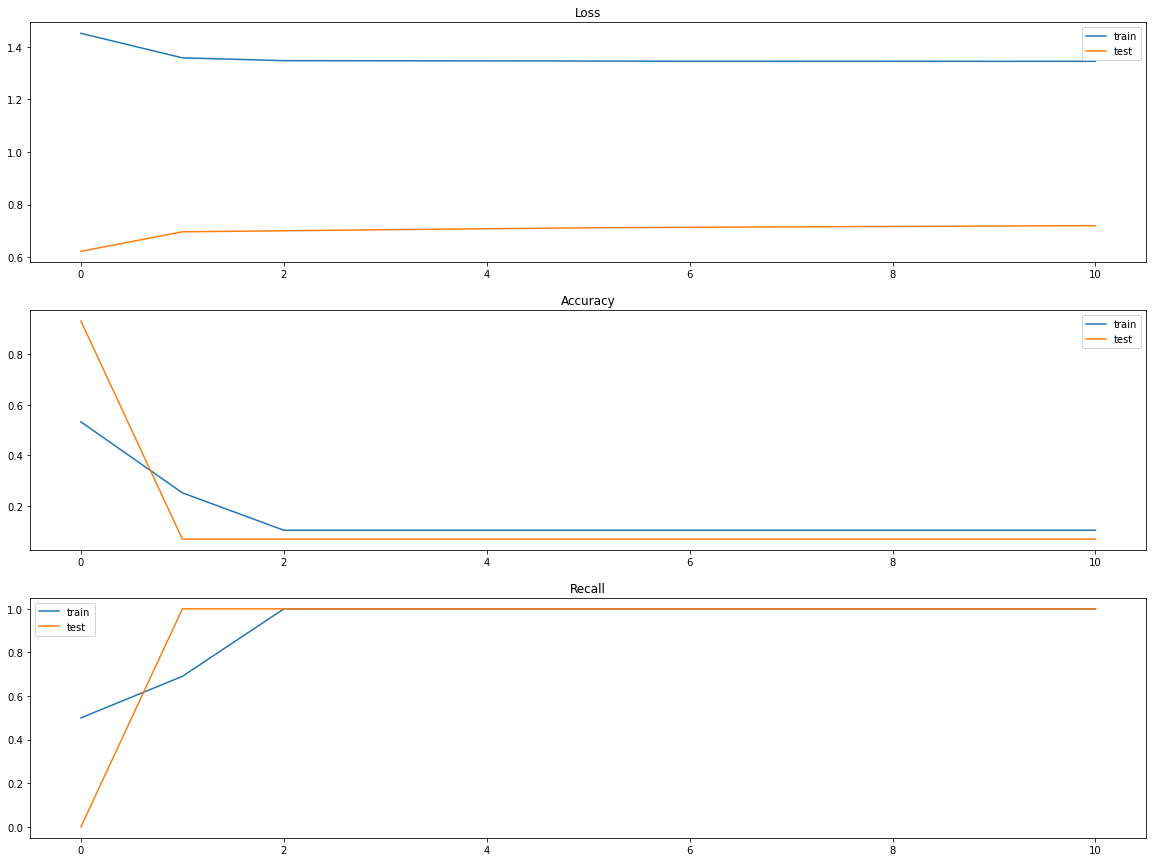

In [17]:
from matplotlib import pyplot

_, axs = pyplot.subplots(3, 1, figsize=(20,15))

# plot loss during training
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='test')
axs[0].set_title("Loss")
axs[0].legend()

# plot accuracy during training
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='test')
axs[1].set_title("Accuracy")
axs[1].legend()

# plot recall during training
axs[2].plot(history.history['recall'], label='train')
axs[2].plot(history.history['val_recall'], label='test')
axs[2].set_title("Recall")
axs[2].legend()

if export_results:
    pyplot.savefig(export_folder + "/loss_and_accuracy_during_training_"+datetime.datetime.now().strftime(date_format)+".png")

pyplot.show()

#### Predict test set

In [18]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

#### Print report

In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, digits=4)
print(f'\nClassification_report=\n{report}')

if export_results:
    file = open(export_folder + "/classification_report_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
    file.write(report)
    file.close()


Classification_report=
              precision    recall  f1-score   support

           0     0.9300    1.0000    0.9637        93
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.9300       100
   macro avg     0.4650    0.5000    0.4819       100
weighted avg     0.8649    0.9300    0.8963       100



/opt/anaconda-2022.05/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda-2022.05/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda-2022.05/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

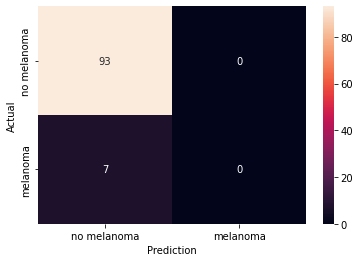

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["no melanoma", "melanoma"]

cf = confusion_matrix(y_test, y_pred)
plot = sns.heatmap(cf, annot= True, fmt=".0f",
           xticklabels = class_names,
           yticklabels = class_names)
plot.set(xlabel='Prediction', ylabel='Actual')

if export_results:
    plot.get_figure().savefig(export_folder + '/confusion_matrix_' + datetime.datetime.now().strftime(date_format) + ".png")

#### Display images and predictions

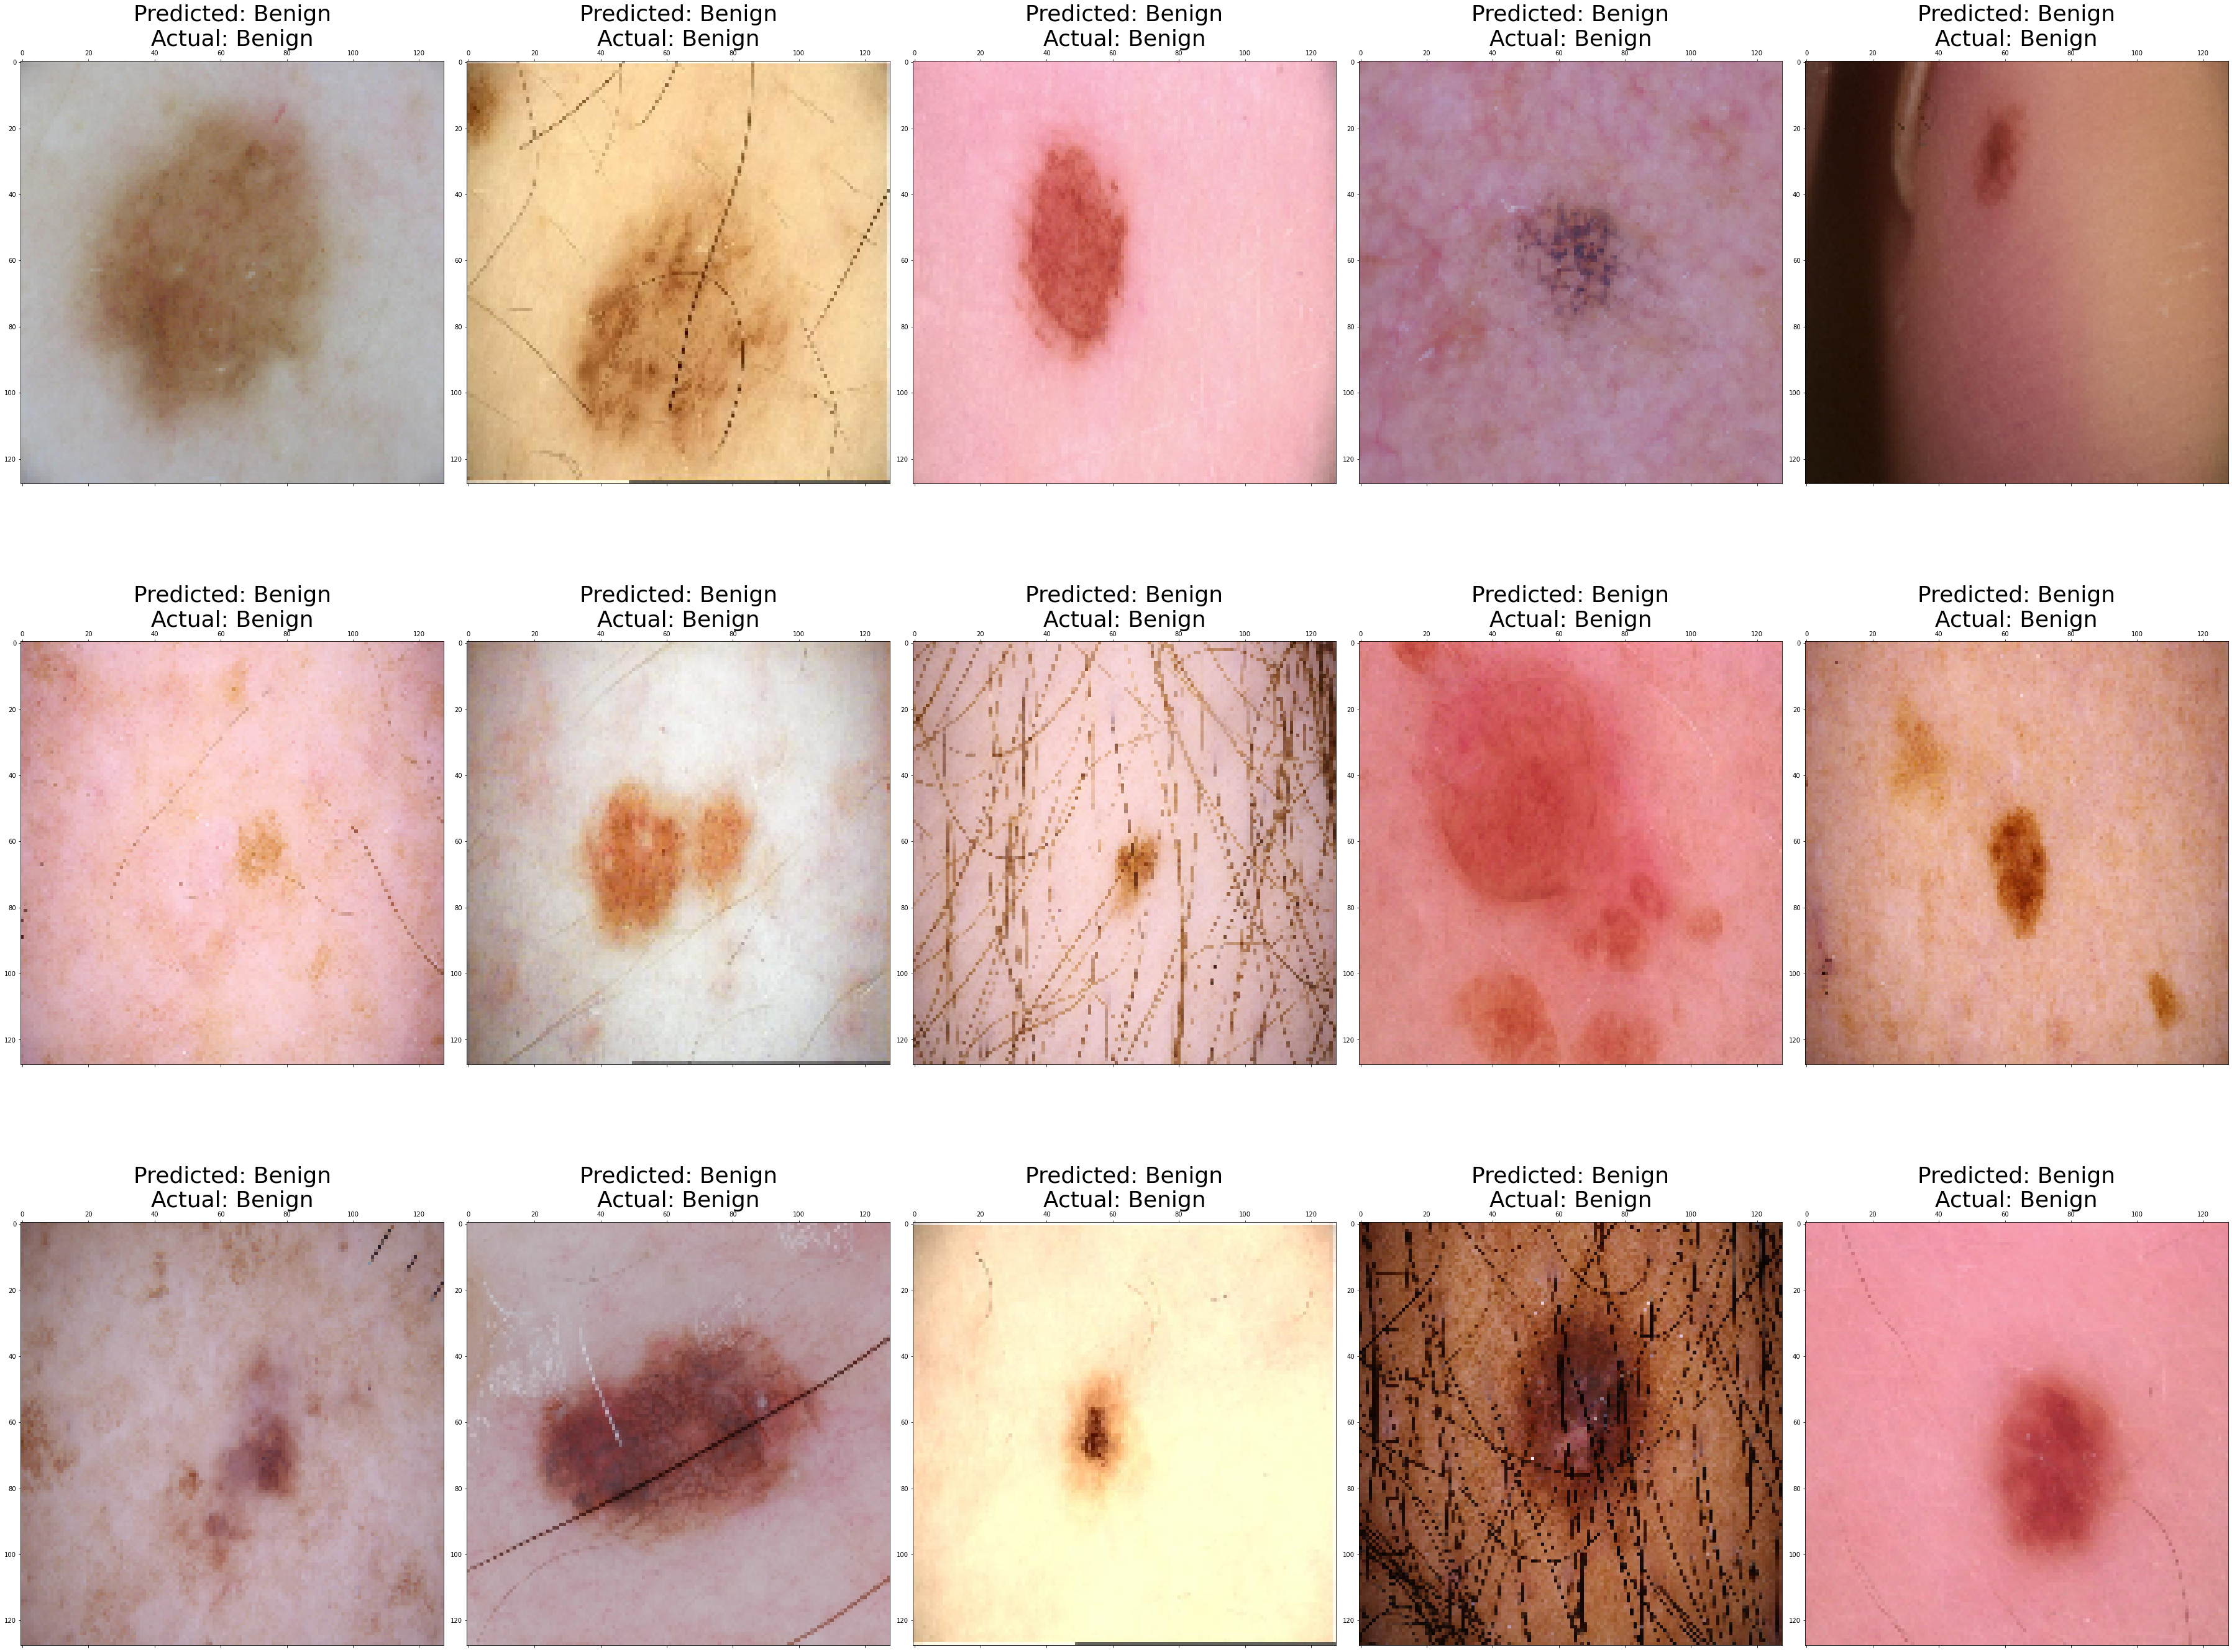

In [21]:
from utilities import display_results

plt_all = display_results(X_test, y_pred, y_test, 15)

if export_results:
    plt_all.savefig(export_folder + "/classification_results_"+datetime.datetime.now().strftime(date_format)+".png")

plt_all.show()

#### Display wrongly classified images

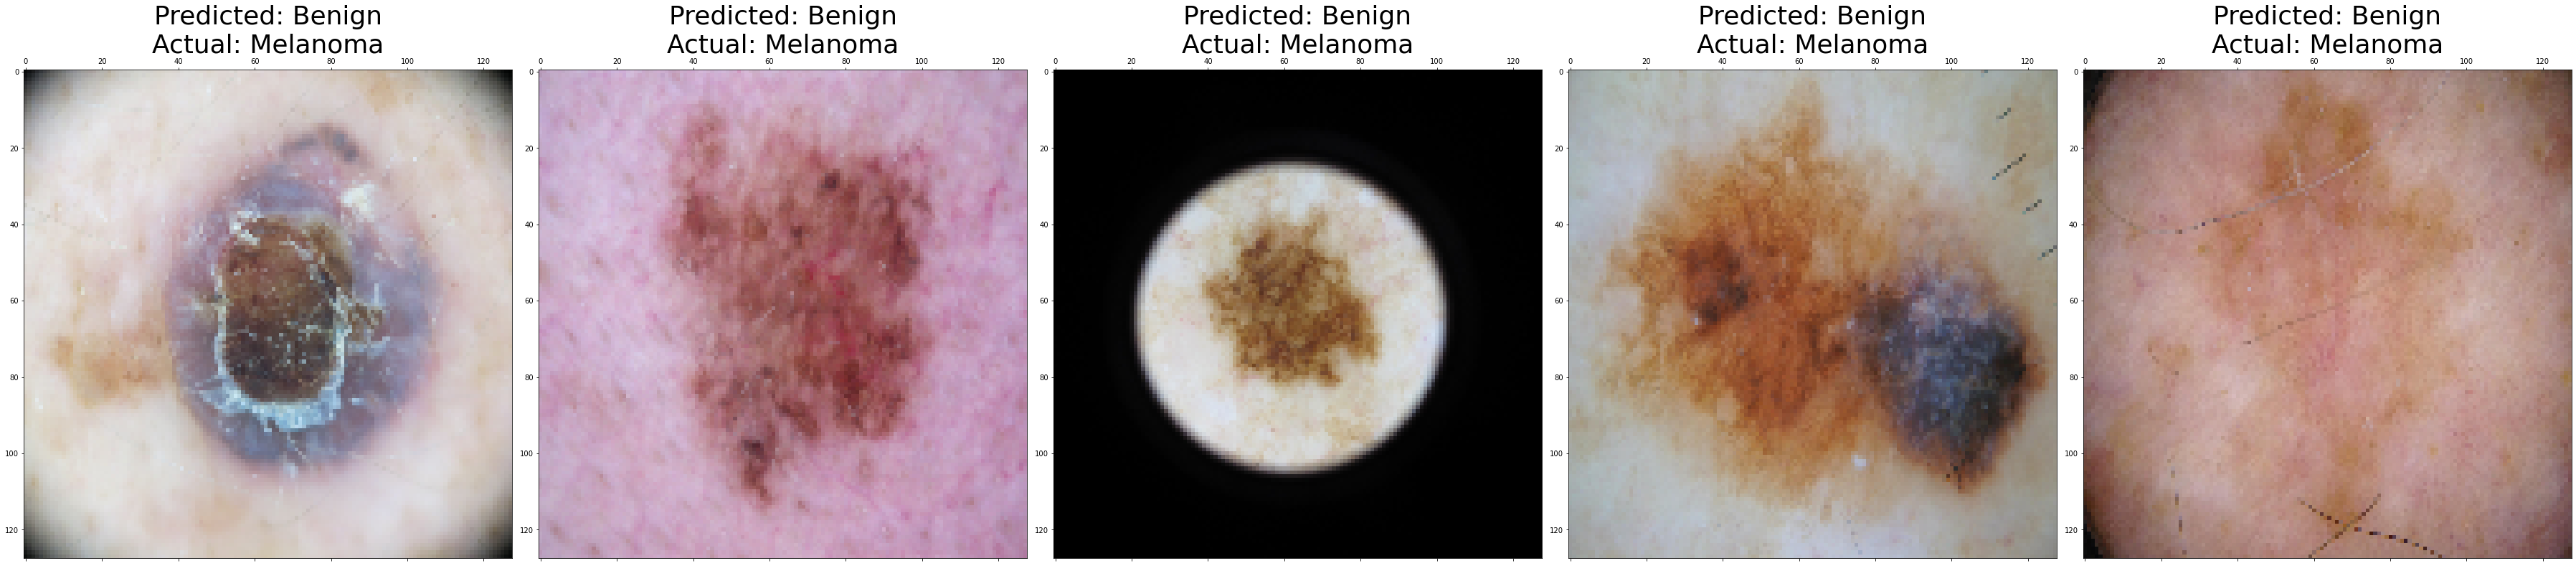

In [22]:
from utilities import display_interesting_results

plt_wrong = display_interesting_results(X_test, y_pred, y_test)

if export_results:
    plt_wrong.savefig(export_folder + "/incorrect_classification_results_"+datetime.datetime.now().strftime(date_format)+".png")
    
plt_wrong.show()